# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [2]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 19, 9, 30, 34, 517939)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [3]:
# UNCOMMENT if not running as a GitHub action
# with open('../data/hopsworks-api-key.txt', 'r') as file:
#     os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1159324
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [4]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='6.357394E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float'], gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [7]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read(read_options={"use_hive": True})
batch_data

2024-11-19 09:30:48,297 WARNING: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated

Finished: Reading data from Hopsworks, using Hive (162.22s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-20,4.30,0.0,21.142147,312.92996,brno
1,2024-11-21,2.95,0.0,17.238699,241.29414,brno
2,2024-11-22,-1.00,0.0,5.588703,255.06853,brno
3,2024-11-23,2.30,0.0,10.805999,271.90912,brno
4,2024-11-24,3.15,0.0,14.843180,129.09386,brno
5,2024-11-25,7.70,0.0,7.968939,198.43504,brno
6,2024-11-26,9.25,0.0,16.750640,261.34753,brno
7,2024-11-27,5.50,0.0,1.484318,104.03627,brno


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [8]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
0,2024-11-20,4.30,0.0,21.142147,312.92996,brno,59.722816
1,2024-11-21,2.95,0.0,17.238699,241.29414,brno,69.686775
2,2024-11-22,-1.00,0.0,5.588703,255.06853,brno,122.511124
3,2024-11-23,2.30,0.0,10.805999,271.90912,brno,101.459175
4,2024-11-24,3.15,0.0,14.843180,129.09386,brno,94.545395
5,2024-11-25,7.70,0.0,7.968939,198.43504,brno,84.558342
6,2024-11-26,9.25,0.0,16.750640,261.34753,brno,57.356258
7,2024-11-27,5.50,0.0,1.484318,104.03627,brno,94.155098


In [9]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         8 non-null      datetime64[ns]
 1   temperature_2m_mean          8 non-null      float64       
 2   precipitation_sum            8 non-null      float64       
 3   wind_speed_10m_max           8 non-null      float64       
 4   wind_direction_10m_dominant  8 non-null      float64       
 5   city                         8 non-null      object        
 6   predicted_pm25               8 non-null      float32       
dtypes: datetime64[ns](1), float32(1), float64(4), object(1)
memory usage: 548.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [23]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-20,4.30,0.0,21.142147,312.92996,brno,59.722816,svatoplukova,czechia,1
1,2024-11-21,2.95,0.0,17.238699,241.29414,brno,69.686775,svatoplukova,czechia,2
2,2024-11-22,-1.00,0.0,5.588703,255.06853,brno,122.511124,svatoplukova,czechia,3
3,2024-11-23,2.30,0.0,10.805999,271.90912,brno,101.459175,svatoplukova,czechia,4
4,2024-11-24,3.15,0.0,14.843180,129.09386,brno,94.545395,svatoplukova,czechia,5
5,2024-11-25,7.70,0.0,7.968939,198.43504,brno,84.558342,svatoplukova,czechia,6
6,2024-11-26,9.25,0.0,16.750640,261.34753,brno,57.356258,svatoplukova,czechia,7
7,2024-11-27,5.50,0.0,1.484318,104.03627,brno,94.155098,svatoplukova,czechia,8


In [11]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         8 non-null      datetime64[ns]
 1   temperature_2m_mean          8 non-null      float64       
 2   precipitation_sum            8 non-null      float64       
 3   wind_speed_10m_max           8 non-null      float64       
 4   wind_direction_10m_dominant  8 non-null      float64       
 5   city                         8 non-null      object        
 6   predicted_pm25               8 non-null      float32       
 7   street                       8 non-null      object        
 8   country                      8 non-null      object        
 9   days_before_forecast_day     8 non-null      int64         
dtypes: datetime64[ns](1), float32(1), float64(4), int64(1), object(3)
memory usage: 740.0+ bytes


### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2024-11-19 09:33:34,050 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



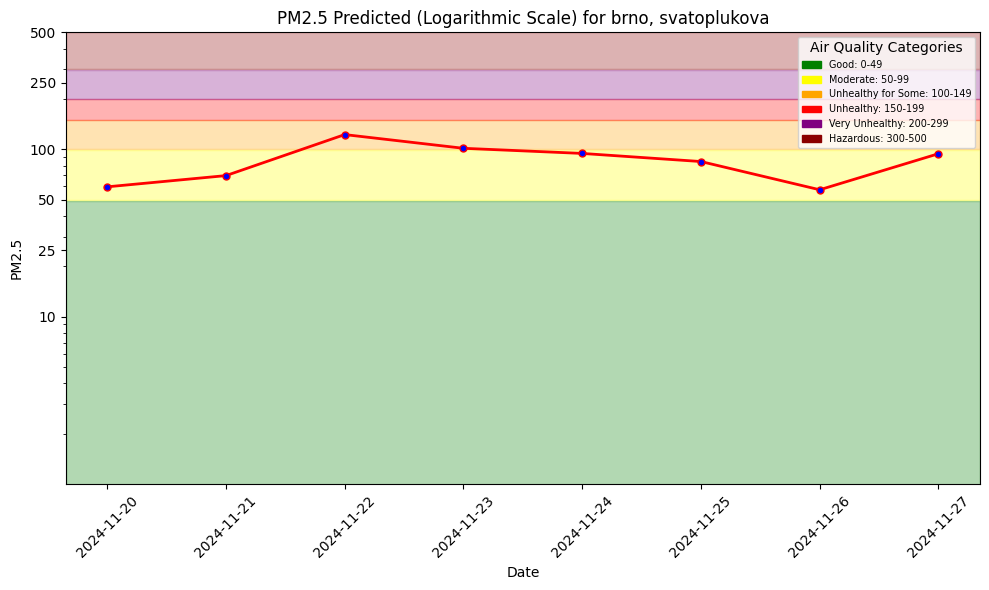

In [12]:
# Prediction path save image
import os

# Ensure the directory exists
output_dir = "../docs/air-quality/assets/img/"
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

file_path = os.path.join(output_dir, "pm25_forecast.png")
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [13]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [27]:
# stupid error
batch_data["precipitation_sum"] = batch_data["precipitation_sum"].astype("float32")
batch_data["temperature_2m_mean"] = batch_data["temperature_2m_mean"].astype("float32")
batch_data["wind_speed_10m_max"] = batch_data["wind_speed_10m_max"].astype("float32")
batch_data["wind_direction_10m_dominant"] = batch_data["wind_direction_10m_dominant"].astype("float32")

In [28]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/8 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1159324/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0xffff5825b4d0>, None)

In [29]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read(read_options={"use_hive": True})
monitoring_df

2024-11-19 10:00:01,272 WARNING: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated

Finished: Reading data from Hopsworks, using Hive (1.62s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-15,8.80,0.0,14.882420,327.84772,brno,82.191870,svatoplukova,czechia,1
1,2024-11-07,10.70,0.0,9.000000,126.86999,brno,83.356544,svatoplukova,czechia,1
2,2024-11-16,8.45,0.0,8.788720,145.00790,brno,76.204220,svatoplukova,czechia,1
3,2024-11-20,4.30,0.0,21.142147,312.92996,brno,59.722816,svatoplukova,czechia,1


In [30]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.select(["date", "pm25"]).read(read_options={"use_hive": True})
air_quality_df

2024-11-19 10:00:09,328 WARNING: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated

Finished: Reading data from Hopsworks, using Hive (2.64s) 


,date,pm25
0,2023-03-09,36.0
1,2024-07-01,34.0
2,2020-07-30,34.0
3,2022-02-11,55.0
4,2021-09-24,30.0
...,...,...
3725,2024-11-17,72.0
3726,2024-11-18,45.0
3727,2024-11-10,102.0
3728,2024-11-08,128.0


In [31]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,pm25
1,2024-11-07,83.356544,99.0
0,2024-11-15,82.191870,50.0
2,2024-11-16,76.204220,59.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

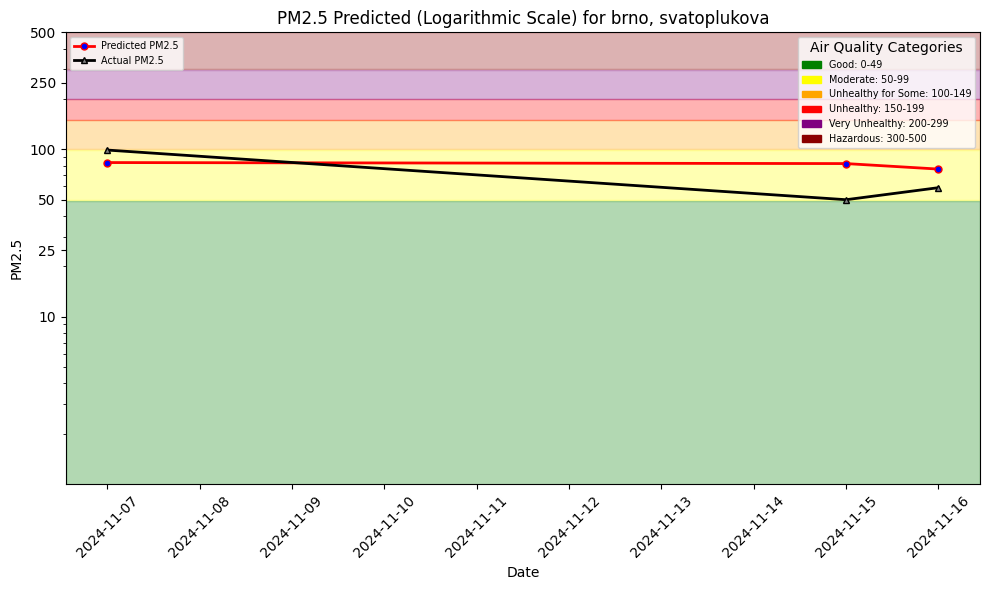

In [32]:
file_path = "../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---